In [1]:
import random
import string
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

In [3]:
import nltk

In [4]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

C:\Users\Balasubramanian\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Balasubramanian\Anaconda2\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
df = pd.read_csv('final.csv')

In [6]:
df_1K = df

In [7]:
print df_1K['label'].value_counts()

2    838
3    237
1    166
4     47
5      5
Name: label, dtype: int64


## Pre-processing
Integer of frequency counts

#### Count Dict

In [8]:
word_count_dict = {}

In [9]:
for index,row in df_1K.iterrows():
    s = row['Summary']
    words = nltk.word_tokenize(s)
    words=[word.lower() for word in words if word.isalpha()]
    for i in words:
        try:
            word_count_dict[i]+=1
        except:
            word_count_dict[i]=1

In [10]:
wc_list = sorted(word_count_dict.items(), key=lambda x: x[1],reverse=True)

In [11]:
wc_dict = {}
ct_no = 1
for item in wc_list:
    wc_dict[item[0]] = ct_no
    ct_no+=1

#### Changing the input to freq-count form

In [14]:
X_list = []
y_list = []
for index,row in df_1K.iterrows():
    y_list.append(int(row['label']))
    iwords = []
    s = row['Summary']
    words = nltk.word_tokenize(s)
    words=[word.lower() for word in words if word.isalpha()]
    for item in words:
        iwords.append(wc_dict[item])
    X_list.append(iwords)

In [16]:
X = np.array(X_list)
y = np.array(y_list)

In [17]:
maxx = 0
maxs = ""
for index,row in df_1K.iterrows():
    s = row['Summary']
    l = len(s)
    if(l>maxx):
        maxx = l
        maxs = s
print 'Max len in document:',maxx
print maxs

Max len in document: 474
A suspect on a motorized scooter approached a student who was walking near the location, demanded her wallet and threatened to shoot her if she did not comply. When the student stated that she did not have any money the suspect forced her to walk to a nearby ATM where she was unable to make a withdrawal. The suspect then followed the student to her residence where she located a box filled with coins. The student handed over the coins and the suspect fled on the scooter.


In [36]:
from keras.utils.np_utils import to_categorical
cy = to_categorical(y, num_classes=None)
#cy

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, cy, test_size=0.3, stratify = cy)

In [38]:
# truncate and pad input sequences
max_review_length = 474
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [39]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(1675, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(6, activation='sigmoid'))

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 474, 32)           53600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 107,406
Trainable params: 107,406
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
905/905 [==============================] - 59s 65ms/step - loss: 1.7237 - acc: 0.6022
Epoch 2/10
905/905 [==============================] - 32s 35ms/step - loss: 1.1656 - acc: 0.6486
Epoch 3/10
905/905 [==============================] - 31s 35ms/step - loss: 1.0121 - acc: 0.6486
Epoch 4/10
905/905 [==============================] - 31s 35ms/step - loss: 1.0001 - acc: 0.6486
Epoch 5/10
905/905 [==============================] - 31s 34ms/step - loss: 0.9894 - acc: 0.6486
Epoch 6/10
905/905 [==============================] - 40s 44ms/step - loss: 0.9761 - acc: 0.6486
Epoch 7/10
905/905 [==============================] - 45s 49ms/step - loss: 0.9639 - acc: 0.6486
Epoch 8/10
905/905 [==============================] - 31s 34ms/step - loss: 0.9442 - acc: 0.6486
Epoch 9/10
905/905 [==============================] - 31s 35ms/step - loss: 0.9154 - acc: 0.6486
Epoch 10/10
905/905 [==============================] - 31s 34ms/step - loss: 0.8894 - acc: 0.6486


In [42]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.69%


In [48]:
pred = model.predict_classes(X_test)

In [49]:
yt = []
for item in y_test:
    ctr = 0
    for i in item:
        if(i==1):
            yt.append(ctr)
        ctr+=1

In [50]:
pred2 =  model.predict(X_test)

In [51]:
print metrics.accuracy_score(yt, pred)

0.6469072164948454


In [52]:
print metrics.classification_report(yt, pred)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        50
          2       0.65      1.00      0.79       251
          3       0.00      0.00      0.00        71
          4       0.00      0.00      0.00        14
          5       0.00      0.00      0.00         2

avg / total       0.42      0.65      0.51       388



### ROC Curve

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [54]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

In [57]:
y_score = pred2

In [58]:
for i in range(1,6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [59]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [60]:
n_classes = 5
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,6)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(1,6):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

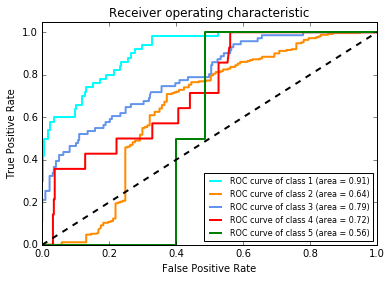

In [61]:
# Plot all ROC curves
lw = 2
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red','green'])
for i, color in zip(range(1,6), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size': 8})
plt.show()